In [9]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ast # For safe evaluation
import random
import os
import random
import numpy as np

In [10]:
# Define the CNN architecture (must be the same as during training)
class CharacterRecognizerCNN(nn.Module):
    def __init__(self, num_classes):
        super(CharacterRecognizerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1_input_size = 128 * (45 // (2**3)) * (45 // (2**3)) # Assuming img_size = 45
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

        self.img_size = 45

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.fc1_input_size)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Load the class names (important for mapping predictions back to characters)
data_dir = '/Users/gvklok/Documents/CST-425/MathSolver/Dataset' # Adjust if needed
train_dir = os.path.join(data_dir, 'train')
train_dataset = datasets.ImageFolder(train_dir) # No transform needed here
class_names = train_dataset.classes
num_classes = len(class_names)

# Load the trained model
model = CharacterRecognizerCNN(num_classes)
model.load_state_dict(torch.load('/Users/gvklok/Documents/CST-425/MathSolver/character_recognizer.pth'))
model.eval() # Set the model to evaluation mode for inference

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

print("Trained model loaded.")
print(f"Class names: {class_names}")

Trained model loaded.
Class names: ['decimal', 'divide', 'eight', 'equal', 'five', 'four', 'minus', 'nine', 'one', 'plus', 'seven', 'six', 'three', 'times', 'two', 'zero']


/var/folders/5p/9g5d24r916j78rp17ymd9l0w0000gn/T/ipykernel_68595/1441623411.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/gvk

In [11]:
def equation_generator(numbers=2, max_num=101):
    assert numbers > 1, "You need at least two numbers to generate a valid equation"
    # Generate numbers and operators
    generated_eqn = []
    operators = ['+', '-', '*', '/'] # Include division
    for _ in range(numbers):
        gen_num = np.random.randint(1, max_num + 1) # Avoid zero for division simplicity
        generated_eqn.append(str(gen_num))
        if _ < numbers - 1:
            operator = random.choice(operators)
            generated_eqn.append(operator)
    # Turn into string
    generated_eqn_str = ''.join(generated_eqn)
    try:
        ans = eval(generated_eqn_str)
        ans_string = '=' + str(ans)
        return generated_eqn_str + ans_string
    except ZeroDivisionError:
        return equation_generator(numbers, max_num) # Regenerate if division by zero occurs
    except Exception as e:
        print(f"Error evaluating equation: {generated_eqn_str} - {e}")
        return None # Or handle the error as you see fit

# Generate a test equation
test_equation_with_answer = equation_generator(numbers=3, max_num=10)
print(f"Generated test equation: {test_equation_with_answer}")

Generated test equation: 4-4*1=0


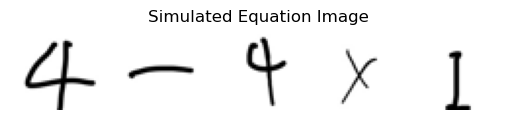

In [16]:
import random
from PIL import Image

def random_sample_file(directory):
    # Randomly selects a file from a directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    if not files:
        return None
    return os.path.join(directory, random.choice(files))

def generate_equation_image(equation_string, character_folder_path, target_height=45, crop_bottom_percent=0.1): # Added crop_bottom_percent
    digit_map = {
        '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
        '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine'
    }
    image_list = []
    for char in equation_string:
        if char in digit_map:
            char_folder = os.path.join(character_folder_path, digit_map[char])
        elif char == '*':
            char_folder = os.path.join(character_folder_path, 'times')
        elif char == '/':
            char_folder = os.path.join(character_folder_path, 'divide')
        elif char == '+':
            char_folder = os.path.join(character_folder_path, 'plus')
        elif char == '-':
            char_folder = os.path.join(character_folder_path, 'minus')
        elif char == '=':
            char_folder = os.path.join(character_folder_path, 'equal')
        elif char == '.':
            char_folder = os.path.join(character_folder_path, 'decimal')
        else:
            print(f"Warning: Unknown character '{char}' in equation")
            continue

        image_file = random_sample_file(char_folder)
        if image_file:
            img = Image.open(image_file).convert('L') # Open as grayscale
            # Resize to target height while maintaining aspect ratio
            aspect_ratio = img.width / img.height
            new_width = int(target_height * aspect_ratio)
            img = img.resize((new_width, target_height))

            # Crop from the bottom
            crop_pixels = int(target_height * crop_bottom_percent)
            img = img.crop((0, 0, img.width, img.height - crop_pixels))

            image_list.append(img)
        else:
            print(f"Warning: No image found for character '{char}' in '{char_folder}'")
            return None

    if not image_list:
        return None

    # Concatenate images horizontally
    total_width = sum(img.width for img in image_list)
    max_height = max(img.height for img in image_list)
    combined_image = Image.new('L', (total_width, max_height), color=255) # White background

    x_offset = 0
    for img in image_list:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return combined_image

# Example usage (you can adjust crop_bottom_percent if needed):
character_dataset_path = '/Users/gvklok/Documents/CST-425/MathSolver/Dataset/train' # Adjust this to your training data path
if test_equation_with_answer:
    equation_image = generate_equation_image(test_equation_with_answer.split('=')[0], character_dataset_path, crop_bottom_percent=0.1) # Crop 10% from the bottom
    if equation_image:
        plt.imshow(equation_image, cmap='gray')
        plt.title("Simulated Equation Image")
        plt.axis('off')
        plt.show()

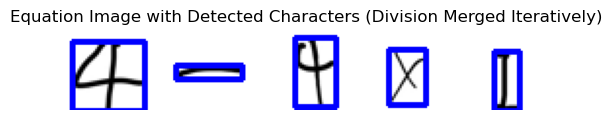

Detected 5 character regions


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Make sure this is imported

def is_fully_within_x(inner_rect, outer_rect):
    """Checks if the x-range of inner_rect is fully within outer_rect."""
    inner_x_start, _, inner_width, _ = inner_rect
    outer_x_start, _, outer_width, _ = outer_rect
    return outer_x_start <= inner_x_start and (inner_x_start + inner_width) <= (outer_x_start + outer_width)

def merge_rects(rect1, rect2):
    """Merges two bounding boxes into one."""
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y
    return (new_x, new_y, new_w, new_h)

def detect_contours_and_merge_division(image):
    # Convert PIL Image to OpenCV format (NumPy array)
    open_cv_image = np.array(image)
    # Convert RGB to grayscale if it's a color image
    if len(open_cv_image.shape) == 3:
        gray = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)
    else:
        gray = open_cv_image

    # Binarize the image
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get initial bounding boxes
    rects = [cv2.boundingRect(cnt) for cnt in contours]
    if not rects:
        return []

    # Sort bounding boxes by x-coordinate
    rects.sort(key=lambda x: x[0])

    merged = True
    while merged:
        merged = False
        new_rects = []
        n = len(rects)
        merged_indices = [False] * n
        for i in range(n):
            if not merged_indices[i]:
                current_rect = rects[i]
                for j in range(i + 1, n):
                    if not merged_indices[j]:
                        other_rect = rects[j]
                        if is_fully_within_x(current_rect, other_rect) or is_fully_within_x(other_rect, current_rect):
                            current_rect = merge_rects(current_rect, other_rect)
                            merged_indices[i] = True
                            merged_indices[j] = True
                            merged = True
                new_rects.append(current_rect)
        rects = new_rects

    # Filter out very small boxes (potential noise)
    min_area = 20
    filtered_rects = [(x, y, w, h) for x, y, w, h in rects if w * h > min_area]
    return filtered_rects

# Example usage (assuming 'equation_image' is a PIL Image object):
if 'equation_image' in locals():
    bounding_boxes = detect_contours_and_merge_division(equation_image)

    # Draw bounding boxes on the image for visualization
    image_with_boxes = np.array(equation_image).copy()
    if len(image_with_boxes.shape) == 2:
        image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_GRAY2BGR)
    else:
        image_with_boxes = image_with_boxes.copy()

    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 0, 255), 2) # Red boxes

    plt.imshow(image_with_boxes)
    plt.title("Equation Image with Detected Characters (Division Merged Iteratively)")
    plt.axis('off')
    plt.show()

    print(f"Detected {len(bounding_boxes)} character regions")
else:
    print("Please load 'equation_image' (a PIL Image object) to run the example.")

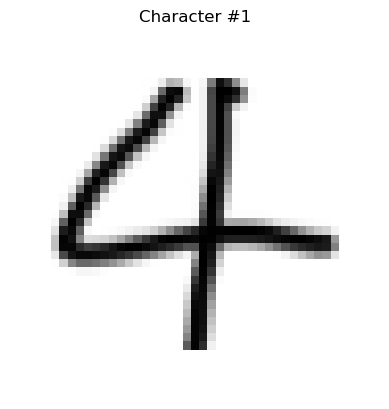

Recognized: 4


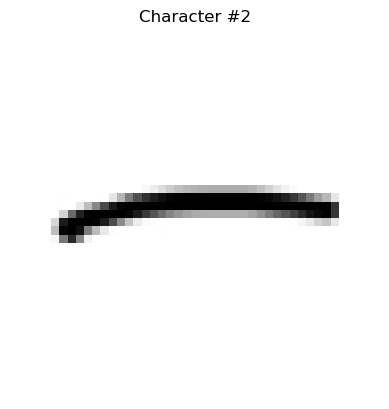

Recognized: -


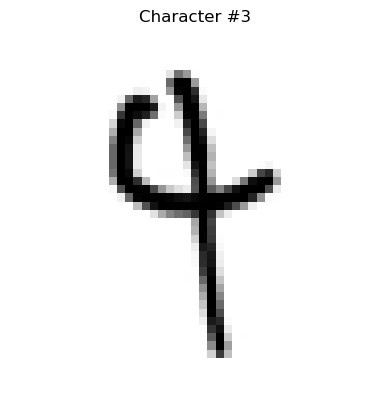

Recognized: 4


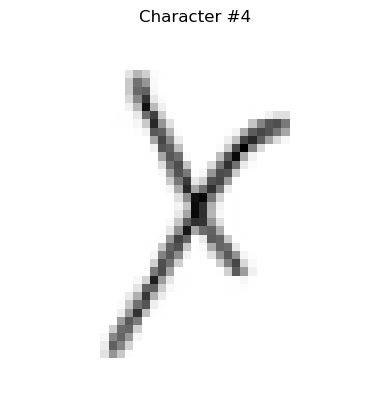

Recognized: ×


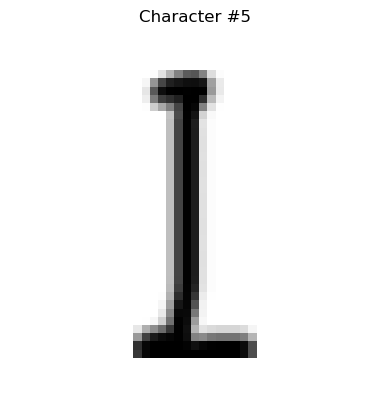

Recognized: 1

Recognized Equation: 4-4*1
Answer: 0


In [21]:
import matplotlib.pyplot as plt
# Add the new preprocess_symbol function here
def preprocess_symbol(char_roi, target_size=(45, 45), padding=5):
    """
    Process the cropped symbol to maintain its aspect ratio and quality:
    1. Create a blank (white) square image of the target size
    2. Resize the symbol while maintaining aspect ratio
    3. Center the symbol in the blank image
    """
    # Create a white background image
    background = np.ones((target_size[0], target_size[1]), dtype=np.uint8) * 255
    
    # Get dimensions of the character ROI
    h, w = char_roi.shape[:2]
    
    # Calculate the aspect ratio and determine new dimensions
    aspect_ratio = w / h
    
    # Calculate new dimensions while maintaining aspect ratio
    # Leave some padding around the character
    max_dim = max(target_size) - (padding * 2)
    
    if aspect_ratio > 1:  # Width is greater than height
        new_width = max_dim
        new_height = int(new_width / aspect_ratio)
    else:  # Height is greater than or equal to width
        new_height = max_dim
        new_width = int(new_height * aspect_ratio)
    
    # Resize the character image
    resized_char = cv2.resize(char_roi, (new_width, new_height), 
                             interpolation=cv2.INTER_AREA)
    
    # Calculate position to center the character in the background
    x_offset = (target_size[1] - new_width) // 2
    y_offset = (target_size[0] - new_height) // 2
    
    # Place the character in the center of the background
    background[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_char
    
    return background

# Mapping from class names to readable characters
symbol_map = {
    "plus": "+",
    "minus": "-",
    "times": "×",
    "divide": "÷",
    "equals": "=",
    "decimal": ".",
    "one": "1",
    "two": "2",
    "three": "3",
    "four": "4",
    "five": "5",
    "six": "6",
    "seven": "7",
    "eight": "8",
    "nine": "9",
    "zero": "0",
    # Add more if needed
}

# Define the transformations - MODIFY THIS PART to remove the resize step
recognition_transforms = transforms.Compose([
    # Removed the resize step since we're handling it in preprocess_symbol
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

recognized_characters = []
if equation_image and bounding_boxes:
    open_cv_image = np.array(equation_image)
    if len(open_cv_image.shape) == 3:
        open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2GRAY)
    for i, (x, y, w, h) in enumerate(sorted(bounding_boxes, key=lambda i: i[0])):
        char_roi = open_cv_image[y:y + h, x:x + w]
        
        # Process the character while maintaining aspect ratio - ADD THIS LINE
        processed_char = preprocess_symbol(char_roi)
        
        # Convert to PIL image - MODIFY THIS LINE
        char_pil = Image.fromarray(processed_char)
        
        # Show the processed character image
        plt.imshow(char_pil, cmap='gray')
        plt.title(f"Character #{i + 1}")
        plt.axis('off')
        plt.show()
        
        # Transform and predict with the processed character
        input_tensor = recognition_transforms(char_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted_idx = torch.max(output, 1)
            predicted_label = class_names[predicted_idx[0]]
            readable_char = symbol_map.get(predicted_label, predicted_label)
            recognized_characters.append(readable_char)
            print(f"Recognized: {readable_char}")

    recognized_equation = "".join(recognized_characters).replace('×', '*').replace('÷', '/')
    try:
        answer = eval(recognized_equation)
        print(f"\nRecognized Equation: {recognized_equation}")
        print(f"Answer: {answer}")
    except (SyntaxError, TypeError, NameError, ZeroDivisionError) as e:
        print(f"\nError evaluating equation: {recognized_equation} - {e}")
else:
    print("No equation image or bounding boxes found.")
